In [1]:
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


 deer  ship  ship horse


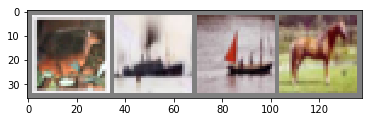

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [4]:
def conv3x3(x,K):
    """3x3 convolution with padding"""
    return F.conv2d(x, K, stride=1, padding=1)

def conv3x3T(x,K):
    """3x3 convolution transpose with padding"""
    #K = torch.transpose(K,0,1)
    return F.conv_transpose2d(x, K, stride=1, padding=1)

def projectTensor(K):         
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):        
            K[i,j,:,:] -= np.mean(K[i,j,:,:],0)
            K[i,j,:,:] -= np.mean(K[i,j,:,:],1)
            return K
        
        
dis = nn.CrossEntropyLoss()
def misfit(X,W,C):
    n = W.shape
    X = X.view(-1,n[0])
    S = torch.matmul(X,W)
    return dis(S,C), S   

def getAccuracy(S,labels):
    _, predicted = torch.max(S.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct/total

Test the projection

In [5]:
outChannels = 16 
inChannels = 3
K  = nn.Parameter(torch.Tensor(outChannels, inChannels,3,3))
#stdv    = 1e-2
#K.data.uniform_(-stdv, stdv)

D = np.random.randn(16,3,3,3)
D = np.float32(D)
D = projectTensor(D)
D = torch.from_numpy(D)
K.data = D 

In [6]:
class ResNet(nn.Module):

    def __init__(self, h,NG):
        super().__init__()

        # network geometry
        self.NG       = NG
        # time step
        self.h        = h
        # coarsening and TV norm
        self.coarsen  = nn.AvgPool2d(32)
        self.coarsen2 = nn.AvgPool2d(2)
        
        
    def forward(self,x,Kresnet):
    
        nt = len(Kresnet)
        
        # time stepping
        for j in range(nt):
            
            # First case - rsent style step
            if NG[0,j] == NG[1,j]: 
                #print(torch.norm(z))
                z  = conv3x3(x, Kresnet[j])
                z  = F.instance_norm(z)
                z  = F.relu(z)        
                z  = conv3x3T(z,Kresnet[j])
                x  = x - self.h*z
            # Change number of channels/resolution    
            else:
                z  = conv3x3(x, Kresnet[j])
                z  = F.instance_norm(z)
                x = F.relu(z)
                if NG[2,j] == 1:
                    x = self.coarsen2(x)
                    
            #q = self.coarsen(x)
            #q = q.view(-1, nc)
            #p = torch.cat((p,q),1)
             
        return x #torch.transpose(p,0,1)
        
   

In [7]:
# initialize net and weights
h           = 1e0

# Network geometry
NG = [3,    64,    64,    64,  64,    256,   256,  
      64,   64,    64,    64,  256,   256,   256,
      1,     0,     0,     0,   1,      0,     0]

NG = np.reshape(NG,(3,-1))
net   = ResNet(h,NG)

nsteps = NG.shape[1]


Kresnet = []
for i in range(nsteps):  
    if NG[0,i] == NG[1,i]:
        Ki  = nn.Parameter(torch.Tensor(np.asscalar(NG[1,i]), np.asscalar(NG[0,i]),3,3))
        D   = np.random.randn(np.asscalar(NG[0,i]), np.asscalar(NG[1,i]),3,3)*1e-3
        D   = np.float32(D)
        D   = projectTensor(D)
        D   = torch.from_numpy(D)
        Ki.data = D
    else:
        Ki = nn.Parameter(torch.Tensor(np.asscalar(NG[1,i]), np.asscalar(NG[0,i]) ,3,3))
        stdv  = 1e-3
        Ki.data.uniform_(-stdv, stdv)
    
    #print(torch.norm(Ki))
    Kresnet.append(Ki)
    
# weights for linear classifier    
W     = nn.Parameter(torch.Tensor(256*8*8,10))
stdv  = 1e-3
W.data.uniform_(-stdv, stdv)
    


tensor([[ 4.3086e-04, -9.2846e-04, -7.8041e-04,  ...,  5.6558e-04,
          3.6937e-04, -6.1010e-04],
        [-4.2038e-05, -9.8353e-04,  5.1653e-05,  ...,  8.3559e-05,
         -8.5675e-04,  7.0505e-06],
        [-2.4509e-04, -4.7181e-04,  5.9074e-04,  ..., -9.9267e-04,
          1.9883e-04,  8.1518e-04],
        ...,
        [ 4.4002e-04,  7.3054e-04,  9.3629e-04,  ...,  9.0439e-04,
         -3.7089e-04,  6.0055e-04],
        [ 8.7209e-04,  1.4891e-06, -8.6735e-04,  ..., -6.2768e-04,
         -1.4930e-04,  3.0003e-05],
        [-8.9189e-04, -8.9765e-04,  6.6231e-05,  ..., -8.0059e-04,
          7.4318e-04,  9.3767e-04]])

In [8]:
torch.norm(Kresnet[1])**2

tensor(1.00000e-02 *
       3.6526)

In [9]:
# run the network
x = net(images,Kresnet)
C = torch.randint(0,10,(4,),dtype=torch.long)

loss,_ = misfit(x,W,C)
print(loss)    


tensor(2.3066)


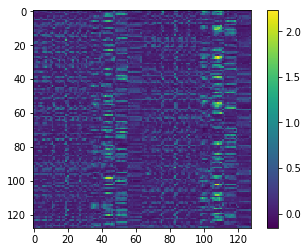

In [10]:
xnp = x.data.numpy()
xnp = np.reshape(xnp,(4,16*8,16*8))
im = plt.imshow(xnp[1,:,:])
plt.colorbar(im)

In [ ]:
import torch.optim as optim
optimizer = optim.SGD([{'params':Kresnet},{'params': W}], lr=1e-4, momentum=0.9)


In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    running_accuracy = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        x    = net(inputs,Kresnet)
        loss, Si = misfit(x,W,labels)
        loss.backward()
             
        optimizer.step()

        # print statistics
        accuracy = getAccuracy(Si,labels)
        running_loss     += loss.item()
        running_accuracy += accuracy
        if i % 200 == 199:    # print every 2000 mini-batches
            # compute validation accuracy
            with torch.no_grad():
                #for data in testloader:
                dataiter = iter(testloader)
                imagesV, labelsV = dataiter.next()
                xV = net(imagesV,Kresnet)
                lossV, SiV = misfit(xV,W,labelsV)
                accuracyV  = getAccuracy(SiV,labelsV)

            
            print('[%d, %5d]  %.3f  %.3f  %.3f' %
                  (epoch + 1, i + 1, running_loss / 200, running_accuracy/200, accuracyV))
            running_loss = 0.0
            running_accuracy = 0.0

print('Finished Training')

[1,   200]  2.286  0.191  0.320
[1,   400]  1.999  0.290  0.340
[1,   600]  1.898  0.336  0.360
[1,   800]  1.815  0.349  0.400
[1,  1000]  1.807  0.374  0.430
[1,  1200]  1.730  0.386  0.480
[1,  1400]  1.613  0.429  0.420
[1,  1600]  1.588  0.432  0.500
[1,  1800]  1.530  0.454  0.500
[1,  2000]  1.592  0.427  0.560
[1,  2200]  1.490  0.461  0.480
[1,  2400]  1.580  0.425  0.480
[1,  2600]  1.485  0.474  0.490
[1,  2800]  1.435  0.499  0.530
[1,  3000]  1.406  0.506  0.520
[1,  3200]  1.458  0.481  0.510
[1,  3400]  1.398  0.506  0.610
[1,  3600]  1.378  0.509  0.550
[1,  3800]  1.350  0.536  0.590
[1,  4000]  1.325  0.531  0.600
[1,  4200]  1.384  0.494  0.550
[1,  4400]  1.343  0.535  0.610
[1,  4600]  1.262  0.568  0.600
[1,  4800]  1.308  0.546  0.600
[1,  5000]  1.284  0.544  0.590
[1,  5200]  1.332  0.526  0.570
[1,  5400]  1.249  0.562  0.650
[1,  5600]  1.291  0.559  0.630
[1,  5800]  1.244  0.574  0.640
[1,  6000]  1.240  0.575  0.660
[1,  6200]  1.216  0.580  0.620
[1,  640

In [ ]:
NG.shape